In [34]:
import sys
import numpy as np
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
from scipy import linalg as la
from itertools import permutations
from functools import partial
import networkx as nx

# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
#import Qconfig

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

# import optimization tools
from qiskit.tools.apps.optimization import trial_circuit_ry, SPSA_optimization, SPSA_calibration
from qiskit.tools.apps.optimization import Energy_Estimate, make_Hamiltonian, eval_hamiltonian, group_paulis
from qiskit.tools.qi.pauli import Pauli

In [35]:
n = 8 # number of data points to cluster

#contain the sample distances between data points
distance_dict = {}
distance_dict['plus'] = [0, 3, 4, 6]
distance_dict['minus'] = [2, 5, 7, 1]


dist_mat = np.zeros((8,8))
for i in range(0, 8):
    for j in range(0,8):
        if i == j :
            dist_mat[i, j] = 0
        elif i in distance_dict['plus']:
            for node in distance_dict['plus']:
                dist_mat[i, node] = 0.1
                dist_mat[i, i] = 0.
            for node in distance_dict['minus']:
                dist_mat[i, node] = 0.8
        elif i in distance_dict['minus']:
            for node in distance_dict['plus']:
                dist_mat[i, node] = 0.8
            for node in distance_dict['minus']:
                dist_mat[i, node] = 0.1
                dist_mat[i, i] = 0.

In [36]:
dist_mat

array([[0. , 0.8, 0.8, 0.1, 0.1, 0.8, 0.1, 0.8],
       [0.8, 0. , 0.1, 0.8, 0.8, 0.1, 0.8, 0.1],
       [0.8, 0.1, 0. , 0.8, 0.8, 0.1, 0.8, 0.1],
       [0.1, 0.8, 0.8, 0. , 0.1, 0.8, 0.1, 0.8],
       [0.1, 0.8, 0.8, 0.1, 0. , 0.8, 0.1, 0.8],
       [0.8, 0.1, 0.1, 0.8, 0.8, 0. , 0.8, 0.1],
       [0.1, 0.8, 0.8, 0.1, 0.1, 0.8, 0. , 0.8],
       [0.8, 0.1, 0.1, 0.8, 0.8, 0.1, 0.8, 0. ]])

/Users/arushigupta/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/arushigupta/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/arushigupta/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


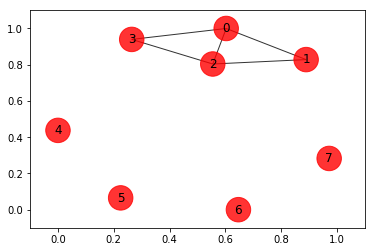

In [37]:


G=nx.Graph()
#add nodes to the graph
G.add_nodes_from(np.arange(0,n,1))

elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)
colors = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
default_axes.set_xlim(-0.1,1.1)
default_axes.set_ylim(-0.1,1.1)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes)

In [38]:
X_matr = np.random.rand(2, n)

In [39]:
#Pauli takes things in reverse order!
pauli_list = []
for i in range(0, n):
    
    w = np.zeros(n)
    v = np.zeros(n)
    #w needs to always be 0
    v[n-i-1] = 1
    pauli_list.append((-1, Pauli(v, w)))

In [40]:
pauli_list[0][1]

In [41]:
HB = make_Hamiltonian(pauli_list)

In [42]:
HB

array([[-8.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -6.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -6.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       ...,
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  6.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  6.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  8.+0.j]])

In [43]:
Q = np.matmul(np.transpose(X_matr),X_matr)

In [44]:
Q

array([[0.92263206, 0.69739119, 1.0868248 , 0.62515877, 0.43129549,
        0.59781413, 0.22295816, 0.97037613],
       [0.69739119, 0.52761186, 0.83363493, 0.47750256, 0.34298279,
        0.45112163, 0.17309858, 0.73962712],
       [1.0868248 , 0.83363493, 1.59104264, 0.86352312, 0.9429118 ,
        0.68501928, 0.37970541, 1.3005166 ],
       [0.62515877, 0.47750256, 0.86352312, 0.4755807 , 0.47008417,
        0.3972229 , 0.19895039, 0.72190225],
       [0.43129549, 0.34298279, 0.9429118 , 0.47008417, 0.81005122,
        0.25261614, 0.26802183, 0.67391148],
       [0.59781413, 0.45112163, 0.68501928, 0.3972229 , 0.25261614,
        0.38853415, 0.13723905, 0.61903189],
       [0.22295816, 0.17309858, 0.37970541, 0.19895039, 0.26802183,
        0.13723905, 0.09797473, 0.29380202],
       [0.97037613, 0.73962712, 1.3005166 , 0.72190225, 0.67391148,
        0.61903189, 0.29380202, 1.10035419]])

In [45]:
Hp = np.zeros((256,256), dtype = 'complex128')
for i in range(0, n):
    for j in range(0, i):
    
        w = np.zeros(n)
        v = np.zeros(n)
        #w needs to always be 0
        v[i] = 1
        
        sigzi = Pauli(v, w).to_matrix()
        w = np.zeros(n)
        v = np.zeros(n)
        v[j] = 1
        sigzj = Pauli(v, w).to_matrix()
        #print(sigzj)
        paul = np.matmul(sigzi, sigzj)
        #print(np.shape(paul))
        Hp += -1.0*Q[i,j]*paul

In [46]:
I_paul = np.eye(2)
for i in range(0, n-1):
    I_paul = np.kron(I_paul, np.eye(2))

In [47]:

for j in range(0, n-1):
    w = np.zeros(n)
    v = np.zeros(n)
    v[j] = 1
    sigzj = np.matmul( -1*2*Q[n-1, j]*Pauli(v, w).to_matrix(), I_paul)
    Hp += sigzj

In [48]:
Hp

array([[-26.49257957+0.j,   0.        +0.j,   0.        +0.j, ...,
          0.        +0.j,   0.        +0.j,   0.        +0.j],
       [  0.        +0.j, -13.34743773+0.j,   0.        +0.j, ...,
          0.        +0.j,   0.        +0.j,   0.        +0.j],
       [  0.        +0.j,   0.        +0.j, -16.1033535 +0.j, ...,
          0.        +0.j,   0.        +0.j,   0.        +0.j],
       ...,
       [  0.        +0.j,   0.        +0.j,   0.        +0.j, ...,
         -0.74370052+0.j,   0.        +0.j,   0.        +0.j],
       [  0.        +0.j,   0.        +0.j,   0.        +0.j, ...,
          0.        +0.j,   0.16622319+0.j,   0.        +0.j],
       [  0.        +0.j,   0.        +0.j,   0.        +0.j, ...,
          0.        +0.j,   0.        +0.j,  -5.21590961+0.j]])

In [49]:
entangler_map = {0: [1], 1: [2], 2: [3]} 

# the coupling_maps gates allowed on the device
coupling_map = None
# the layout of the qubits 
initial_layout = None

# the backend used for the quantum computation
backend = 'local_qasm_simulator' 
# Total number of trial steps used in the optimization
max_trials = 100; 
n = 4 # the number of qubits 
# Depth of the quantum circuit that prepares the trial state
m = 3     
# initial starting point for the control angles
initial_theta=np.random.randn(m*n)   
# number of shots for each evaluation of the cost function (shots=1 corresponds to perfect evaluation, 
# only available on the simulator)
shots = 1
# choose to plot the results of the optimizations every save_steps 
save_step = 1